# Skin Lesion Classification using ML and CV with additional features ##\


### Part 1 - Computer Vision ###

Processing images: 100%|██████████| 660/660 [00:21<00:00, 30.62it/s]



--- PCA Reduction ---
PCA - Original shape: (1000, 20), Reduced shape: (1000, 16)
PCA - Total variance explained: 0.9596

--- LDA Reduction ---
LDA - Original shape: (1000, 20), Reduced shape: (1000, 1)

--- TSNE Reduction ---
t-SNE - Original shape: (1000, 20), Reduced shape: (1000, 2)


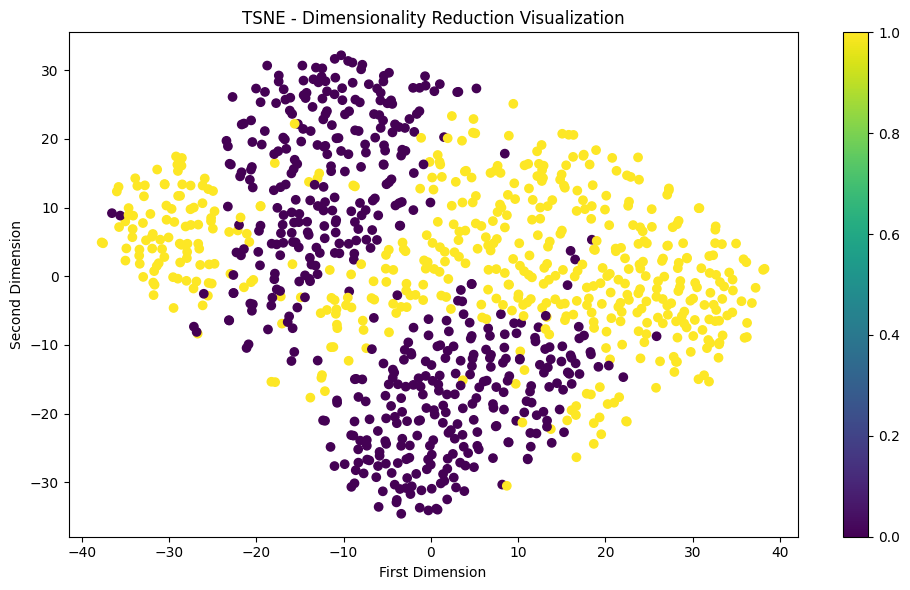


--- RANDOM_PROJECTION Reduction ---
Random Projection - Original shape: (1000, 20), Reduced shape: (1000, 10)

--- SELECTKBEST Reduction ---
SelectKBest - Original shape: (1000, 20), Reduced shape: (1000, 10)


In [7]:
import os
import numpy as np
import cv2
import pandas as pd
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from skimage.filters import threshold_otsu
from scipy.stats import skew
import pywt
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE

def load_dataset(folder_path):
    data = []
    labels = []
    for label in ['malignant', 'benign']:
        folder = os.path.join(folder_path, label)
        for img_name in tqdm(os.listdir(folder), desc=f"Loading {label} images"):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                if len(img.shape) == 2:  # Grayscale image (2D)
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB from BGR
                data.append(img)
                labels.append(label)
    
    return np.array(data), np.array(labels)

def extract_skin_color_features(img):
    features = []
    # Convert image to HSV and YCrCb color spaces
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    # Define HSV and YCrCb skin color ranges
    lower_hsv = np.array([0, 48, 80], dtype="uint8")
    upper_hsv = np.array([20, 255, 255], dtype="uint8")
    lower_ycrcb = np.array([0, 133, 77], dtype="uint8")
    upper_ycrcb = np.array([255, 173, 127], dtype="uint8")
    
    # Mask for HSV and YCrCb color spaces
    skin_mask_hsv = cv2.inRange(hsv, lower_hsv, upper_hsv)
    skin_mask_ycrcb = cv2.inRange(ycrcb, lower_ycrcb, upper_ycrcb)
    
    # Combine the masks
    combined_mask = cv2.bitwise_and(skin_mask_hsv, skin_mask_ycrcb)
    
    # Calculate skin color percentage
    skin_pixel_ratio = np.sum(combined_mask > 0) / (combined_mask.shape[0] * combined_mask.shape[1])
    features.append(skin_pixel_ratio)
    
    # Extract mean and standard deviation from skin pixel regions
    skin_pixels = img[combined_mask > 0]
    if len(skin_pixels) > 0:
        mean_skin_color = np.mean(skin_pixels, axis=0)
        std_skin_color = np.std(skin_pixels, axis=0)
        features.extend(mean_skin_color)
        features.extend(std_skin_color)
    else:
        features.extend([0, 0, 0])  # Mean
        features.extend([0, 0, 0])  # Std
    
    return features  # [skin_pixel_ratio, mean_R, mean_G, mean_B, std_R, std_G, std_B]

def extract_shape_features(img):
    features = []
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0
        features.extend([area, perimeter, circularity])
        
        if len(cnt) >= 5:
            (x, y), (MA, ma), angle = cv2.fitEllipse(cnt)
            asymmetry = MA / ma if ma != 0 else 0
            features.append(asymmetry)
        else:
            features.append(0)
        
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area if hull_area != 0 else 0
        features.append(solidity)
    else:
        features.extend([0] * 5)
    
    return np.array(features).ravel()  # [area, perimeter, circularity, asymmetry, solidity]

def extract_texture_features(img):
    features = []
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # LBP Features
    lbp = local_binary_pattern(gray, 8 * 3, 3, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 8 * 3 + 3), range=(0, 8 * 3 + 2))
    features.extend(hist)
    
    # GLCM Features
    glcm = graycomatrix(gray, [5], [0], 256, symmetric=True, normed=True)
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
        features.append(graycoprops(glcm, prop)[0, 0])
    return np.array(features).ravel()  # LBP histogram bins + GLCM [contrast, dissimilarity, homogeneity, energy, correlation]

def extract_edge_features(img):
    features = []
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Canny Edge Detection
    edges_canny = cv2.Canny(gray, 100, 200)
    edge_density_canny = np.sum(edges_canny) / (edges_canny.shape[0] * edges_canny.shape[1])
    features.append(edge_density_canny)
    
    # Sobel Edge Detection
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edge_density = np.mean(np.abs(sobelx) + np.abs(sobely))
    features.append(sobel_edge_density)
    
    return np.array(features).ravel()  # [Canny edge density, Sobel edge density]


def extract_gabor_features(img, num_kernels=8):
    gabor_features = []
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    for theta in np.arange(0, np.pi, np.pi / num_kernels):
        kernel = cv2.getGaborKernel((31, 31), sigma=4.0, theta=theta, lambd=10.0, gamma=0.5, psi=0)
        filtered_img = cv2.filter2D(img_gray, cv2.CV_8UC3, kernel)
        mean, std_dev = cv2.meanStdDev(filtered_img)
        gabor_features.extend([mean[0][0], std_dev[0][0]])
    
    return gabor_features  # [mean, std_dev for each Gabor orientation]

def extract_hog_features(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hog_features, _ = hog(img_gray, orientations=8, pixels_per_cell=(16, 16), 
                           cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)
    return hog_features


def fractal_dimension(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    threshold = threshold_otsu(gray)
    bin_img = gray < threshold
    sizes = []
    
    # Generate box sizes and calculate number of non-zero pixels at each size
    box_sizes = np.arange(1, 50, 2)
    for box_size in box_sizes:
        resized_img = cv2.resize(bin_img.astype(np.uint8), (box_size, box_size), interpolation=cv2.INTER_NEAREST)
        sizes.append(np.sum(resized_img > 0))
    
    # Remove zero values to avoid log(0) issues
    sizes = [size for size in sizes if size > 0]
    
    # Check if we have enough data points to fit a line
    if len(sizes) > 1:
        # Use matching lengths for x and y
        return [np.polyfit(np.log(box_sizes[:len(sizes)]), np.log(sizes), 1)[0]]
    else:
        # Return 0 if there aren't enough data points
        return [0]

def extract_wavelet_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    coeffs = pywt.wavedec2(gray, 'db1', level=2)
    wavelet_features = []
    for level in coeffs:
        if isinstance(level, tuple):
            for arr in level:
                wavelet_features.extend([np.mean(arr), np.std(arr)])
        else:
            wavelet_features.extend([np.mean(level), np.std(level)])
    return wavelet_features

def extract_entropy_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    entropy_value = shannon_entropy(gray)
    return [entropy_value]

def analyze_lesion(img):
    color_features = extract_skin_color_features(img)
    texture_features = extract_texture_features(img)
    shape_features = extract_shape_features(img)
    gabor_features = extract_gabor_features(img)
    hog_features = extract_hog_features(img)
    edge_features = extract_edge_features(img)
    fractal_features = fractal_dimension(img)
    wavelet_features = extract_wavelet_features(img)
    entropy_features = extract_entropy_features(img)
    return np.concatenate([color_features, texture_features, shape_features, gabor_features, hog_features, edge_features, fractal_features, wavelet_features, entropy_features])

def process_dataset(data, labels):
    features = []
    for img in tqdm(data, desc="Processing images"):
        img_features = analyze_lesion(img)
        features.append(img_features)
    features = np.array(features)
    return features, labels

# Load train and test sets from the data folder
train_data, train_labels = load_dataset("archive/data/train")
test_data, test_labels = load_dataset("archive/data/test")

# Convert labels to binary format
train_labels = np.where(train_labels == 'benign', 0, 1)
test_labels = np.where(test_labels == 'benign', 0, 1)

# Process train and test sets
X_train_raw, y_train = process_dataset(train_data, train_labels)
X_test_raw, y_test = process_dataset(test_data, test_labels)

# Handle NaN values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_raw = imputer.fit_transform(X_train_raw)
X_test_raw = imputer.transform(X_test_raw)

# Standardize the features
scaler = StandardScaler()
X_train_raw = scaler.fit_transform(X_train_raw)
X_test_raw = scaler.transform(X_test_raw)

def perform_dimensionality_reduction(X, y, method='pca'):
    """
    Perform dimensionality reduction using different techniques
    
    Parameters:
    - X: Feature matrix
    - y: Labels
    - method: Reduction technique to use
    
    Returns:
    - Reduced features
    - Method-specific additional information
    """
    
    if method == 'pca':
        # Principal Component Analysis
        reducer = PCA(n_components=0.95)  # Retain 95% variance
        X_reduced = reducer.fit_transform(X)
        extra_info = {
            'explained_variance_ratio': reducer.explained_variance_ratio_,
            'cumulative_variance_ratio': np.cumsum(reducer.explained_variance_ratio_)
        }
        print(f"PCA - Original shape: {X.shape}, Reduced shape: {X_reduced.shape}")
        print(f"PCA - Total variance explained: {sum(reducer.explained_variance_ratio_):.4f}")
    
    elif method == 'lda':
        # Linear Discriminant Analysis
        n_components = min(len(np.unique(y))-1, X.shape[1])
        reducer = LinearDiscriminantAnalysis(n_components=n_components)
        X_reduced = reducer.fit_transform(X, y)
        extra_info = {
            'explained_variance_ratio': reducer.explained_variance_ratio_
        }
        print(f"LDA - Original shape: {X.shape}, Reduced shape: {X_reduced.shape}")
    
    elif method == 'tsne':
        # t-Distributed Stochastic Neighbor Embedding
        reducer = TSNE(n_components=2, random_state=42)
        X_reduced = reducer.fit_transform(X)
        extra_info = {}
        print(f"t-SNE - Original shape: {X.shape}, Reduced shape: {X_reduced.shape}")
    
    elif method == 'random_projection':
        # Gaussian Random Projection
        n_components = min(10, X.shape[1])
        reducer = GaussianRandomProjection(n_components=n_components, random_state=42)
        X_reduced = reducer.fit_transform(X)
        extra_info = {}
        print(f"Random Projection - Original shape: {X.shape}, Reduced shape: {X_reduced.shape}")
    
    elif method == 'selectkbest':
        # Statistical Feature Selection
        n_features = min(10, X.shape[1])
        reducer = SelectKBest(score_func=f_classif, k=n_features)
        X_reduced = reducer.fit_transform(X, y)
        extra_info = {
            'selected_feature_indices': reducer.get_support(indices=True)
        }
        print(f"SelectKBest - Original shape: {X.shape}, Reduced shape: {X_reduced.shape}")
    
    else:
        raise ValueError("Invalid dimensionality reduction method")
    
    return X_reduced, extra_info

def visualize_reduction(X_reduced, y, method):
    """
    Visualize reduced dimensionality data
    """
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(f'{method.upper()} - Dimensionality Reduction Visualization')
    plt.xlabel('First Dimension')
    plt.ylabel('Second Dimension')
    plt.tight_layout()
    plt.show()

def demonstrate_dimensionality_reduction(X, y):
    """
    Demonstrate various dimensionality reduction techniques
    """
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # List of reduction methods to demonstrate
    methods = ['pca', 'lda', 'tsne', 'random_projection', 'selectkbest']
    
    # Store results for each method
    reduction_results = {}
    
    for method in methods:
        print(f"\n--- {method.upper()} Reduction ---")
        
        try:
            # Reduce dimensionality
            X_reduced, extra_info = perform_dimensionality_reduction(X_scaled, y, method)
            
            # Store results
            reduction_results[method] = {
                'reduced_data': X_reduced,
                'extra_info': extra_info
            }
            
            # Visualize for 2D methods
            if X_reduced.shape[1] == 2:
                visualize_reduction(X_reduced, y, method)
            
        except Exception as e:
            print(f"Error with {method} reduction: {e}")
    
    return reduction_results

# Example usage (you would replace this with your actual data loading)
def main():
    # Simulated data generation for demonstration
    from sklearn.datasets import make_classification
    
    # Generate a synthetic dataset
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, 
                                n_classes=2, random_state=42)
    
    # Demonstrate dimensionality reduction
    reduction_results = demonstrate_dimensionality_reduction(X, y)
    
    return reduction_results

# Run the main function
if __name__ == "__main__":
    results = main()


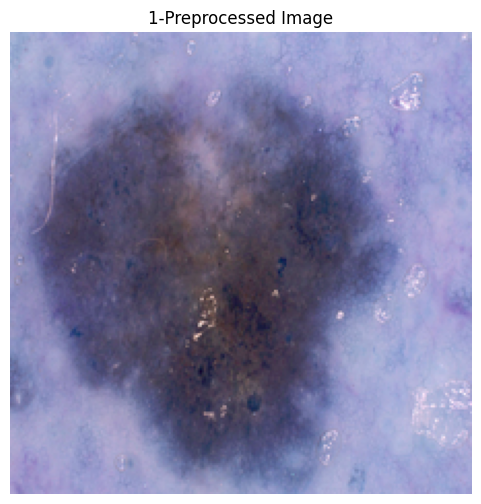

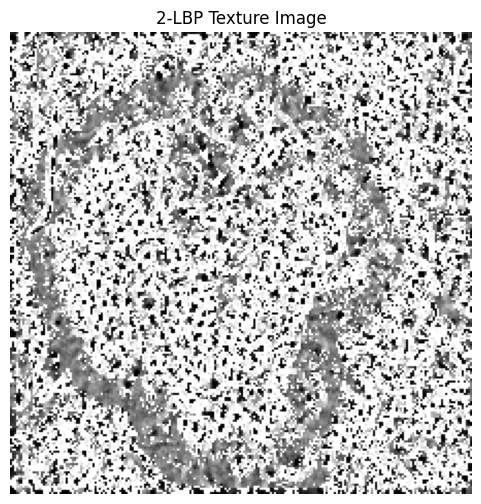

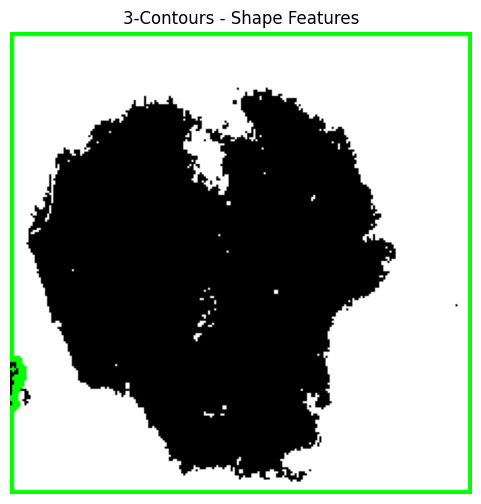

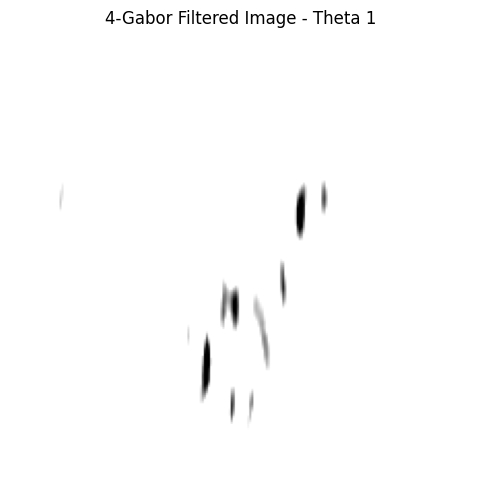

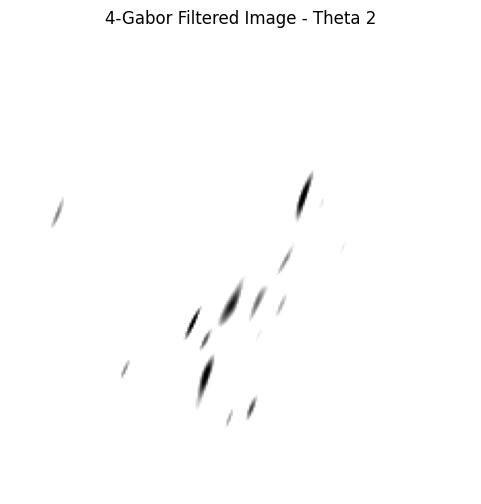

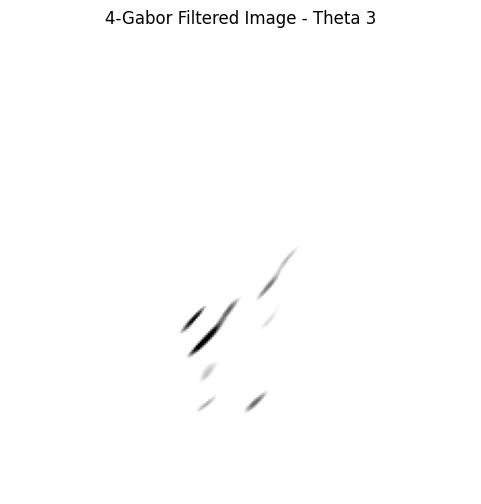

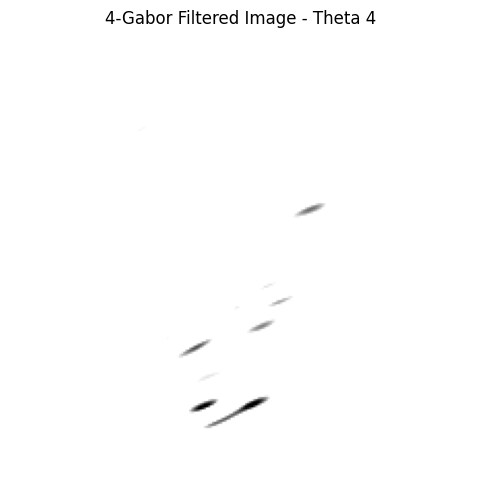

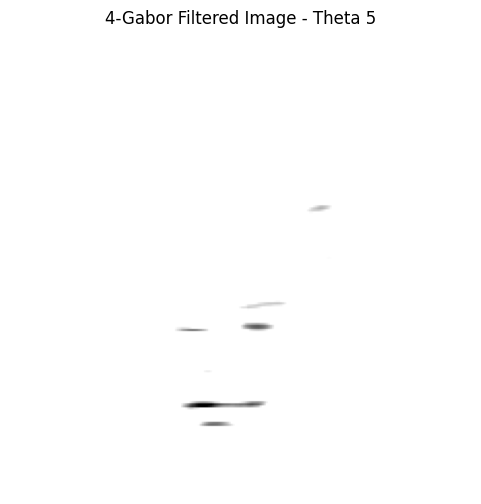

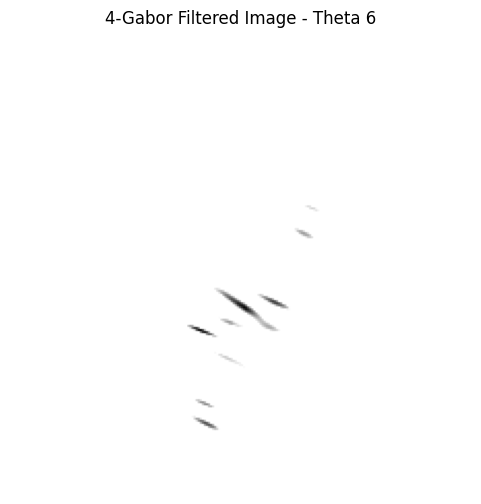

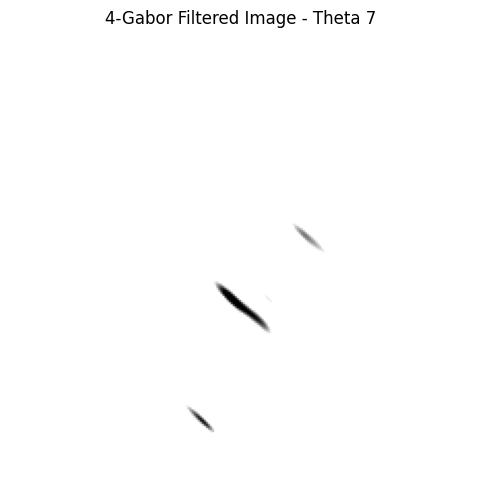

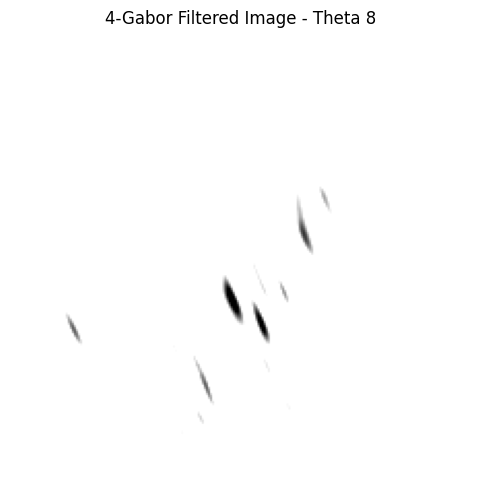

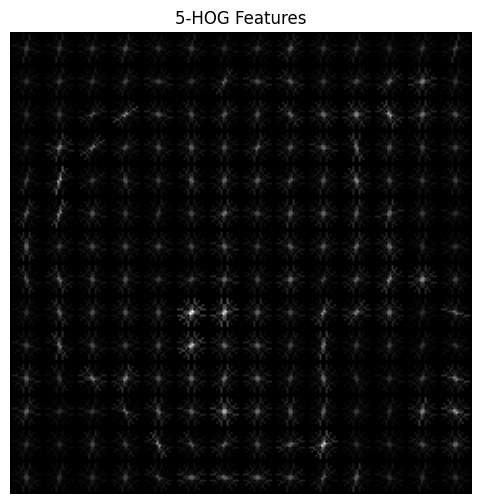

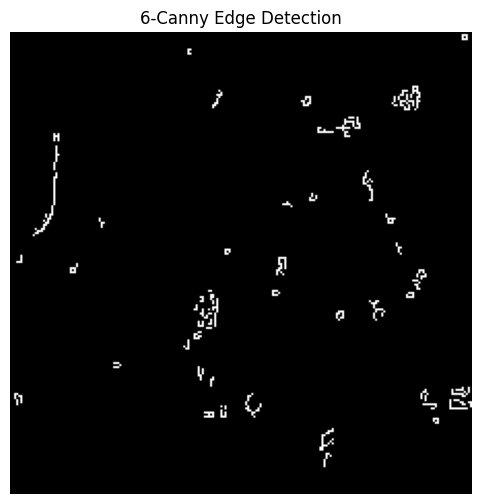

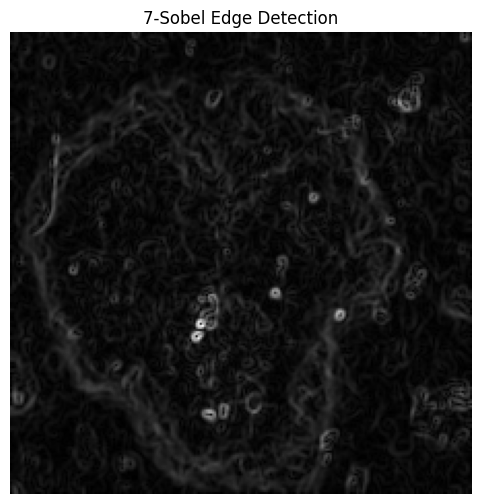

Fractal Dimension: -1.984030815872547


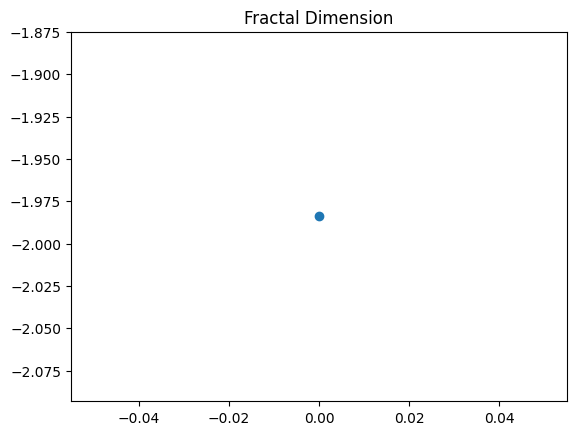

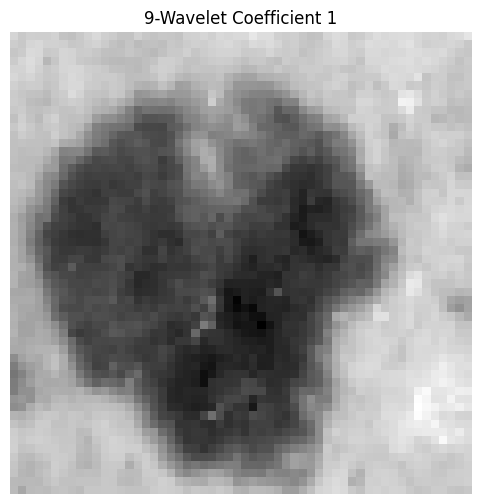

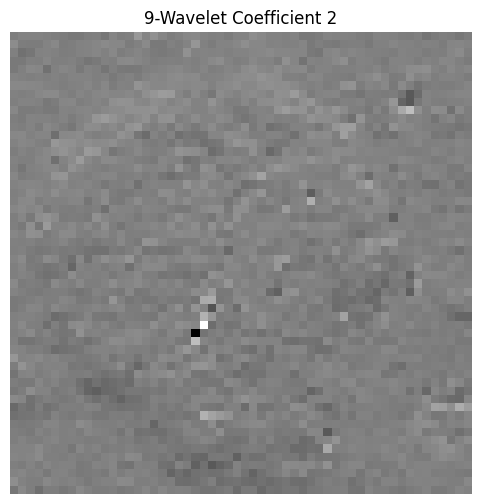

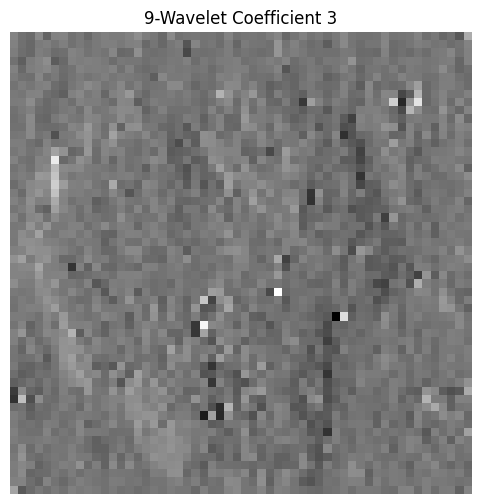

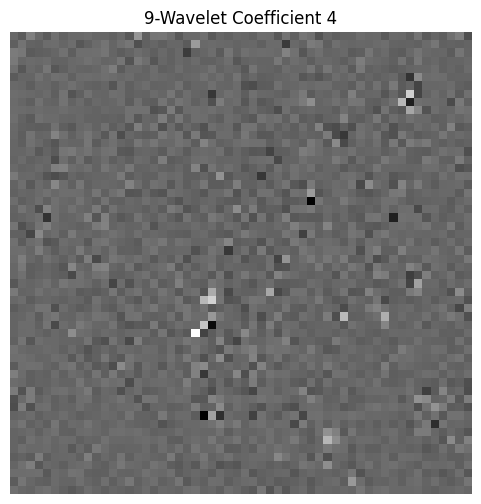

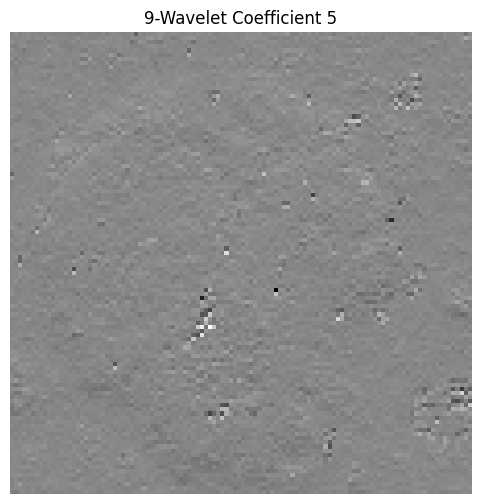

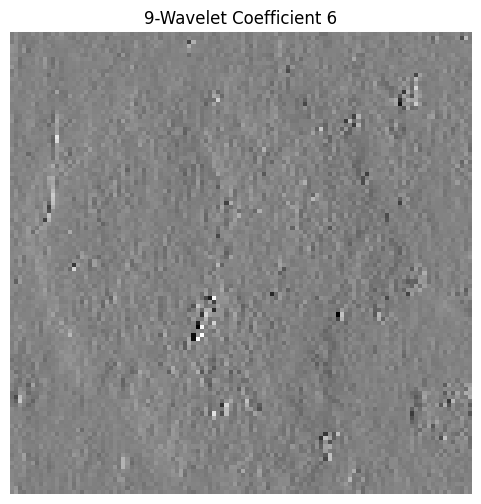

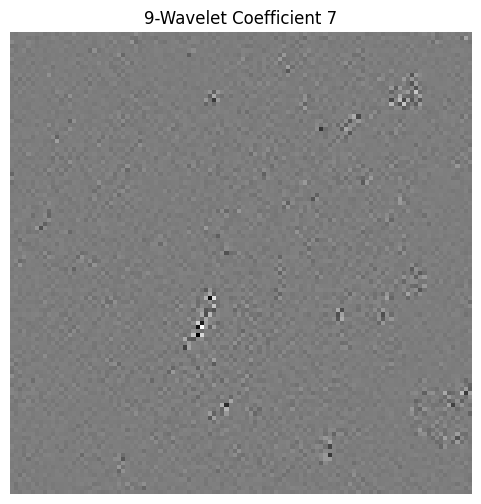

Entropy: 6.975935128960222


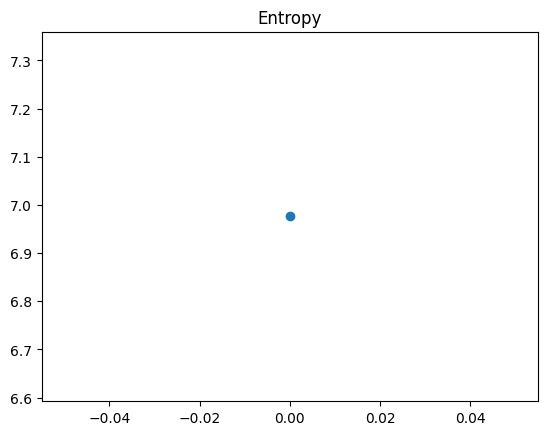

In [31]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog
from skimage.measure import shannon_entropy
import pywt
from tqdm import tqdm

# Set up output folder
output_folder = "output_images"
os.makedirs(output_folder, exist_ok=True)

# Function to save and display images or feature plots
def save_and_show_image(image, step_name, is_feature=False):
    """ Save and show images or feature plots. """
    file_path = os.path.join(output_folder, f"{step_name}.png")
    
    plt.figure(figsize=(6, 6))
    
    if is_feature:
        plt.plot(image)  # For feature array visualization
        plt.title(f"{step_name} - Feature Array")
    else:
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        plt.axis('off')
        plt.title(step_name)
    
    plt.savefig(file_path)
    plt.show()

# Sample image preprocessing
def preprocess_image(image):
    """ Preprocess the image (grayscale conversion, resizing, etc.) """
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Sample, convert to RGB
sample_image = preprocess_image(train_data[1])  # Ensure train_data is defined properly
save_and_show_image(sample_image, "1-Preprocessed Image")

# Convert to grayscale if not already
if len(sample_image.shape) == 3:
    gray_img = cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY)
else:
    gray_img = sample_image

# LBP Texture Feature
lbp_image = local_binary_pattern(gray_img, 24, 3, method='uniform')
save_and_show_image(lbp_image, "2-LBP Texture Image")

# Shape Feature Visualization: Contours
_, binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
save_and_show_image(contour_img, "3-Contours - Shape Features")

# Gabor Filter Visualization
for i, theta in enumerate(np.arange(0, np.pi, np.pi / 8)):
    kernel = cv2.getGaborKernel((31, 31), sigma=4.0, theta=theta, lambd=10.0, gamma=0.5, psi=0)
    gabor_image = cv2.filter2D(gray_img, cv2.CV_8UC3, kernel)
    save_and_show_image(gabor_image, f"4-Gabor Filtered Image - Theta {i+1}")

# HOG Feature Visualization
hog_features, hog_image = hog(gray_img, orientations=8, pixels_per_cell=(16, 16),
                              cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)
save_and_show_image(hog_image, "5-HOG Features")

# Canny Edge Detection
canny_edges = cv2.Canny(gray_img, 100, 200)
save_and_show_image(canny_edges, "6-Canny Edge Detection")

# Sobel Edge Detection
sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=5)
sobel_edges = cv2.magnitude(sobelx, sobely)
sobel_edges = cv2.normalize(sobel_edges, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
save_and_show_image(sobel_edges, "7-Sobel Edge Detection")

# Fractal Dimension Calculation
def fractal_dimension(img, threshold=128):
    """Calculate the fractal dimension using the box-counting method."""
    # Convert the image to binary
    _, binary = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    
    # Sizes for the box-counting method
    sizes = np.arange(2, min(binary.shape) // 2, 2)
    counts = []
    for size in sizes:
        # Resize and count the filled boxes
        resized_img = cv2.resize(binary, (size, size), interpolation=cv2.INTER_NEAREST)
        count = np.sum(resized_img > 0)
        counts.append(count)
    
    # Convert counts to a numpy array and filter out zero counts
    counts = np.array(counts)
    valid_sizes = sizes[counts > 0]
    valid_counts = counts[counts > 0]

    # Calculate the log of sizes and counts
    log_sizes = np.log(valid_sizes)
    log_counts = np.log(valid_counts)

    # Perform linear regression to estimate the fractal dimension
    if len(log_sizes) > 1 and len(log_counts) > 1:
        coeffs = np.polyfit(log_sizes, log_counts, 1)
        fractal_dim = -coeffs[0]
        return fractal_dim
    else:
        return None

# Example usage with a grayscale image
fractal_dim = fractal_dimension(gray_img)
if fractal_dim is not None:
    print("Fractal Dimension:", fractal_dim)
    plt.figure()
    plt.plot([fractal_dim], marker='o')
    plt.title("Fractal Dimension")
    plt.savefig("output_images/fractal_dimension.png")
    plt.show()
else:
    print("Fractal dimension calculation failed.")

# Wavelet Transform Function
def wavelet_transform(img):
    """Apply 2-level discrete wavelet transform and visualize coefficients."""
    coeffs2 = pywt.wavedec2(img, 'db1', level=2)
    wavelet_features = []
    for i, coeff in enumerate(coeffs2):
        if i == 0:
            # Approximation coefficients at the coarsest level
            cA = coeff
            wavelet_features.append(cA)
        else:
            # Horizontal, Vertical, and Diagonal detail coefficients
            cH, cV, cD = coeff
            wavelet_features.extend([cH, cV, cD])
    return wavelet_features

wavelet_coeffs = wavelet_transform(gray_img)
for i, coeff in enumerate(wavelet_coeffs):
    save_and_show_image(coeff, f"9-Wavelet Coefficient {i+1}")

# Shannon Entropy Calculation
def calculate_entropy(img):
    """Calculate Shannon entropy for the grayscale image."""
    if img.ndim == 3:  # Convert to grayscale if necessary
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    entropy_value = shannon_entropy(img)
    return entropy_value

# Calculate entropy and visualize
entropy_value = calculate_entropy(gray_img)
if entropy_value is not None:
    print("Entropy:", entropy_value)
    plt.figure()
    plt.plot([entropy_value], marker='o')
    plt.title("Entropy")
    plt.savefig("output_images/entropy.png")
    plt.show()
else:
    print("Entropy calculation failed.")


### Part 2 - Machine Learning ###

##### Support Vector Machine #####

Performing Grid Search for SVM Kernels...

SVM Best Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'sigmoid'}
SVM Best Cross-Validation Score: 0.7785

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       360
           1       0.77      0.81      0.79       300

    accuracy                           0.81       660
   macro avg       0.81      0.81      0.81       660
weighted avg       0.81      0.81      0.81       660



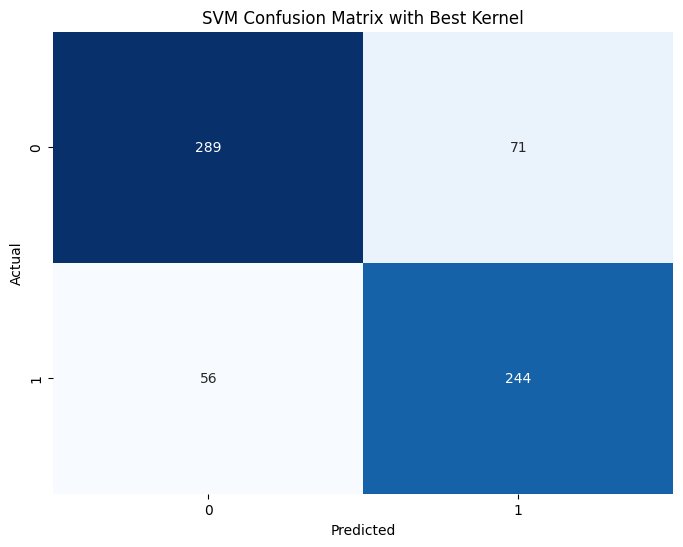

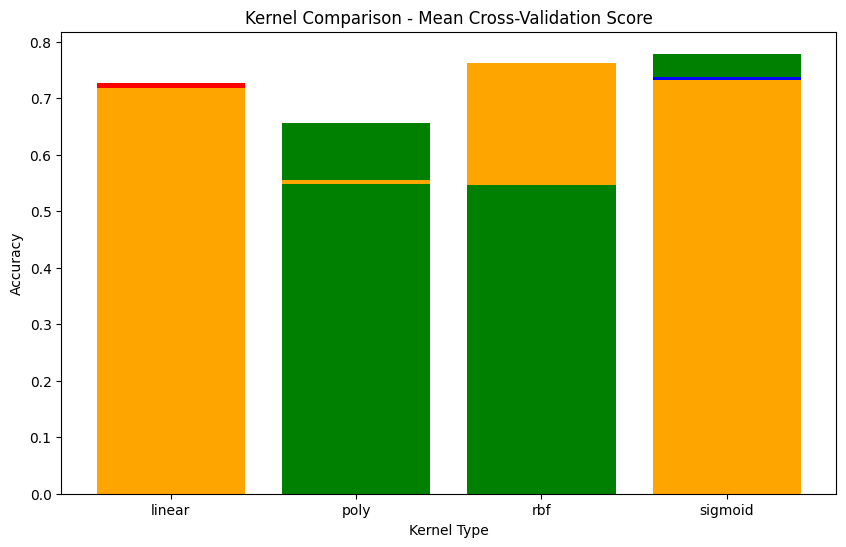

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM Parameter Grid for Different Kernels
svm_param_grid = [
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100]
    },
    {
        'kernel': ['poly'],
        'C': [0.1, 1, 10],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
    },
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 1]
    },
    {
        'kernel': ['sigmoid'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    }
]

# Perform Grid Search for SVM
print("Performing Grid Search for SVM Kernels...\n")
svm_grid = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=5, n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

# Best Parameters and Score
print("SVM Best Parameters:", svm_grid.best_params_)
print("SVM Best Cross-Validation Score:", np.round(svm_grid.best_score_, 4))

# Predictions and Evaluation on Test Set
svm_pred = svm_grid.predict(X_test_scaled)
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
svm_cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("SVM Confusion Matrix with Best Kernel")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Kernel Comparison Summary
kernel_results = svm_grid.cv_results_
kernel_names = [str(params['kernel']) for params in kernel_results['params']]
mean_test_scores = kernel_results['mean_test_score']

# Plot Kernel Comparison
plt.figure(figsize=(10, 6))
plt.bar(kernel_names, mean_test_scores, color=['red', 'green', 'blue', 'orange'])
plt.title("Kernel Comparison - Mean Cross-Validation Score")
plt.ylabel("Accuracy")
plt.xlabel("Kernel Type")
plt.show()


##### Multi Layer Perceptron #####

/Users/arnavkarnik/Documents/Skin-Lesions-classifications-and-Development-of-GUI/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Training MLP with layers=[50], activation=relu, learning_rate=0.001


/Users/arnavkarnik/Documents/Skin-Lesions-classifications-and-Development-of-GUI/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Accuracy: 0.7909
Training MLP with layers=[50], activation=relu, learning_rate=0.01
Validation Accuracy: 0.7712
Training MLP with layers=[50], activation=tanh, learning_rate=0.001
Validation Accuracy: 0.7894
Training MLP with layers=[50], activation=tanh, learning_rate=0.01
Validation Accuracy: 0.7652
Training MLP with layers=[100], activation=relu, learning_rate=0.001
Validation Accuracy: 0.8015
Training MLP with layers=[100], activation=relu, learning_rate=0.01
Validation Accuracy: 0.7773
Training MLP with layers=[100], activation=tanh, learning_rate=0.001
Validation Accuracy: 0.7742
Training MLP with layers=[100], activation=tanh, learning_rate=0.01
Validation Accuracy: 0.7879
Training MLP with layers=[50, 50], activation=relu, learning_rate=0.001
Validation Accuracy: 0.7470
Training MLP with layers=[50, 50], activation=relu, learning_rate=0.01
Validation Accuracy: 0.7394
Training MLP with layers=[50, 50], activation=tanh, learning_rate=0.001
Validation Accuracy: 0.7742
T

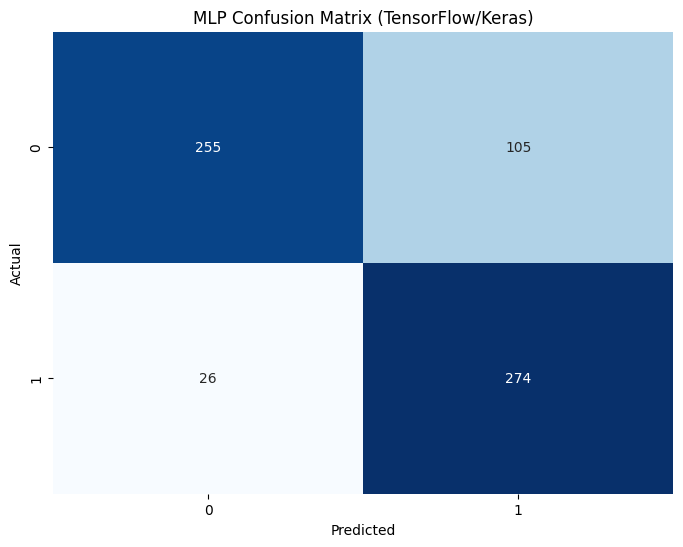

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert target to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Define a function to build an MLP model with TensorFlow/Keras
def build_mlp(input_dim, hidden_layer_sizes, activation='relu', learning_rate=0.001):
    model = Sequential()
    # Input layer + Hidden layers
    for i, layer_size in enumerate(hidden_layer_sizes):
        if i == 0:
            model.add(Dense(layer_size, activation=activation, input_dim=input_dim))
        else:
            model.add(Dense(layer_size, activation=activation))
    # Output layer
    model.add(Dense(y_train_categorical.shape[1], activation='softmax'))
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define hyperparameters for tuning
hidden_layer_configs = [[50], [100], [50, 50], [100, 50]]
activations = ['relu', 'tanh']
learning_rates = [0.001, 0.01]
best_accuracy = 0
best_model = None
best_config = {}

# Perform manual Grid Search
for hidden_layers in hidden_layer_configs:
    for activation in activations:
        for lr in learning_rates:
            print(f"Training MLP with layers={hidden_layers}, activation={activation}, learning_rate={lr}")
            model = build_mlp(input_dim=X_train_scaled.shape[1],
                              hidden_layer_sizes=hidden_layers,
                              activation=activation,
                              learning_rate=lr)
            # Train the model
            history = model.fit(X_train_scaled, y_train_categorical,
                                validation_split=0.2, epochs=50, batch_size=32, verbose=0)
            # Evaluate the model
            loss, accuracy = model.evaluate(X_test_scaled, y_test_categorical, verbose=0)
            print(f"Validation Accuracy: {accuracy:.4f}")
            
            # Save the best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                best_config = {'layers': hidden_layers, 'activation': activation, 'learning_rate': lr}

# Print best model configuration
print("\nBest Model Configuration:")
print(f"Hidden Layers: {best_config['layers']}")
print(f"Activation: {best_config['activation']}")
print(f"Learning Rate: {best_config['learning_rate']}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Make predictions using the best model
y_pred_probs = best_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("MLP Confusion Matrix (TensorFlow/Keras)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


##### Random Forest Classifier #####

/Users/arnavkarnik/Documents/Skin-Lesions-classifications-and-Development-of-GUI/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimat

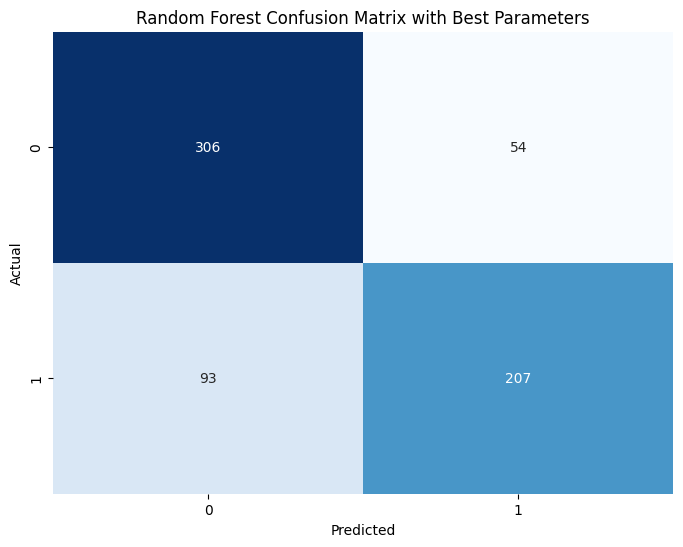

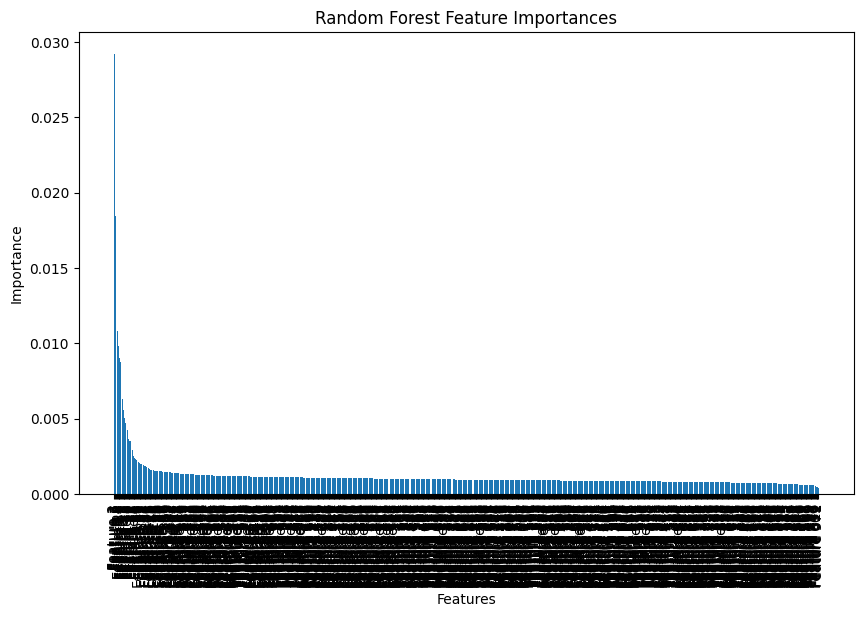

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Hyperparameter Grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],  # Adjusted here from 'auto' to 'sqrt' and 'log2'
    'bootstrap': [True]
}

# Randomized Search CV for Random Forest
rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), 
                               param_distributions=rf_param_grid, 
                               n_iter=100, cv=3, verbose=2, 
                               random_state=42, n_jobs=-1)
rf_random.fit(X_train_scaled, y_train)

# Best Parameters and Score
print("Random Forest Best Parameters:", rf_random.best_params_)
print("Random Forest Best Cross-Validation Score:", np.round(rf_random.best_score_, 4))

# Predictions and Evaluation on Test Set
rf_pred = rf_random.predict(X_test_scaled)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
rf_cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Random Forest Confusion Matrix with Best Parameters")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plotting Feature Importances
plt.figure(figsize=(10, 6))
importances = rf_random.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X_train_scaled.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), [f"Feature {i}" for i in indices], rotation=90)
plt.title("Random Forest Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


##### Ensemble Voting Classifier #####

Training SVM Model with GridSearch...
SVM Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Training MLP Model...


/Users/arnavkarnik/Documents/Skin-Lesions-classifications-and-Development-of-GUI/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Training Random Forest Model with RandomizedSearch...
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Users/arnavkarnik/Documents/Skin-Lesions-classifications-and-Development-of-GUI/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.4s
[CV] END bootstrap=True, max_depth=None, min_sam

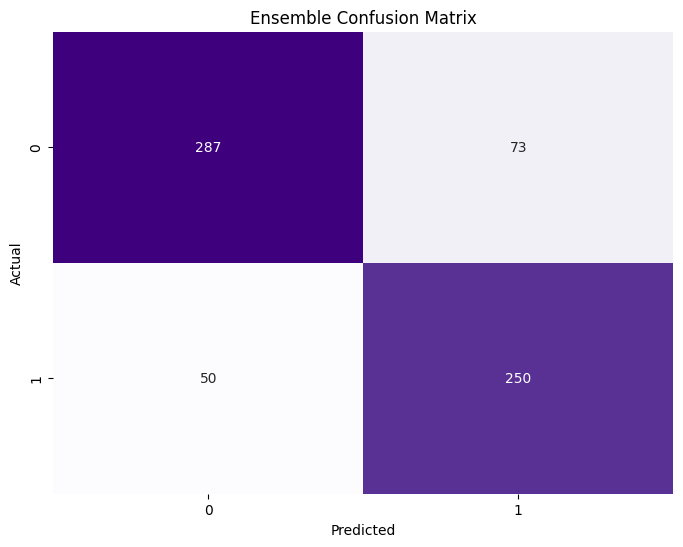


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       360
           1       0.79      0.79      0.79       300

    accuracy                           0.81       660
   macro avg       0.81      0.81      0.81       660
weighted avg       0.81      0.81      0.81       660


MLP Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       360
           1       0.76      0.83      0.79       300

    accuracy                           0.80       660
   macro avg       0.80      0.80      0.80       660
weighted avg       0.81      0.80      0.80       660


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       360
           1       0.80      0.70      0.75       300

    accuracy                           0.78       660
   macro avg       0.79      0.78 

In [25]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np

# --------------------- Data Preprocessing ---------------------
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert target to categorical (for MLP)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# --------------------- Train SVM with GridSearch ---------------------
svm_param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 1]
}

print("Training SVM Model with GridSearch...")
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid, cv=5, n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)
print("SVM Best Parameters:", svm_grid.best_params_)

# SVM predictions
svm_pred_probs = svm_grid.best_estimator_.predict_proba(X_test_scaled)

# --------------------- Train TensorFlow/Keras MLP ---------------------
def build_mlp(input_dim, hidden_layer_sizes, activation='relu', learning_rate=0.001):
    model = Sequential()
    for i, layer_size in enumerate(hidden_layer_sizes):
        if i == 0:
            model.add(Dense(layer_size, activation=activation, input_dim=input_dim))
        else:
            model.add(Dense(layer_size, activation=activation))
    model.add(Dense(y_train_categorical.shape[1], activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train MLP model
print("\nTraining MLP Model...")
mlp_model = build_mlp(input_dim=X_train_scaled.shape[1], hidden_layer_sizes=[50, 50])
mlp_model.fit(X_train_scaled, y_train_categorical, epochs=50, batch_size=32, verbose=0)

# MLP predictions
mlp_pred_probs = mlp_model.predict(X_test_scaled)

# --------------------- Train Random Forest with RandomizedSearch ---------------------
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

print("\nTraining Random Forest Model with RandomizedSearch...")
rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), 
                               param_distributions=rf_param_grid, 
                               n_iter=100, cv=3, verbose=2, 
                               random_state=42, n_jobs=-1)
rf_random.fit(X_train_scaled, y_train)
print("Random Forest Best Parameters:", rf_random.best_params_)

# Random Forest predictions
rf_pred_probs = rf_random.best_estimator_.predict_proba(X_test_scaled)

# --------------------- Ensemble Model ---------------------
# Average predictions (Soft Voting)
ensemble_pred_probs = (svm_pred_probs + mlp_pred_probs + rf_pred_probs) / 3
ensemble_pred = np.argmax(ensemble_pred_probs, axis=1)

# True labels
y_true = y_test

# --------------------- Evaluation ---------------------
print("\nEnsemble Classification Report:")
print(classification_report(y_true, ensemble_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, ensemble_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Compare SVM, MLP, Random Forest, and Ensemble
svm_pred = np.argmax(svm_pred_probs, axis=1)
mlp_pred = np.argmax(mlp_pred_probs, axis=1)
rf_pred = np.argmax(rf_pred_probs, axis=1)

print("\nSVM Classification Report:")
print(classification_report(y_true, svm_pred))

print("\nMLP Classification Report:")
print(classification_report(y_true, mlp_pred))

print("\nRandom Forest Classification Report:")
print(classification_report(y_true, rf_pred))


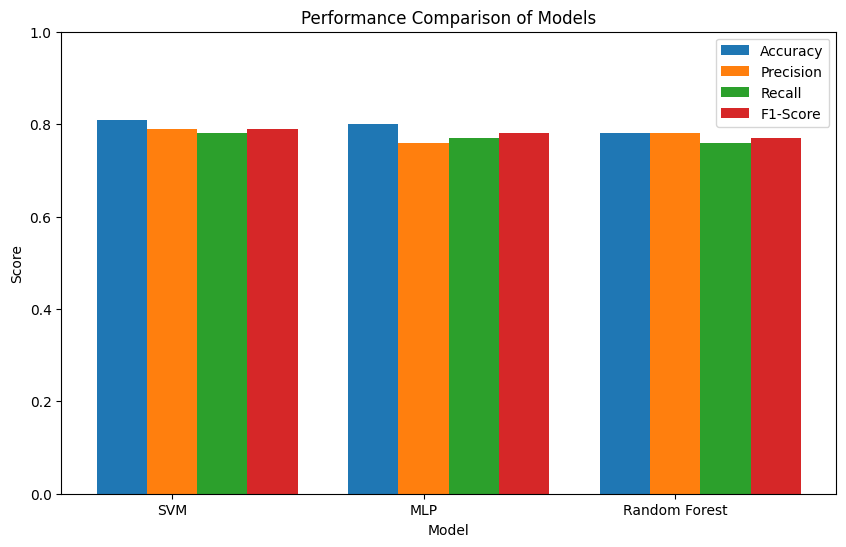

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Example performance metrics (replace these with your actual results)
# Fill in accuracy, precision, recall, and F1-score for each model
metrics = {
    'SVM': {'accuracy': 0.81, 'precision': 0.79, 'recall': 0.78, 'f1_score': 0.79},
    'MLP': {'accuracy': 0.80, 'precision': 0.76, 'recall': 0.77, 'f1_score': 0.78},
    'Random Forest': {'accuracy': 0.78, 'precision': 0.78, 'recall': 0.76, 'f1_score': 0.77}
}

# Extracting each metric for plotting
models = list(metrics.keys())
accuracy = [metrics[model]['accuracy'] for model in models]
precision = [metrics[model]['precision'] for model in models]
recall = [metrics[model]['recall'] for model in models]
f1_score = [metrics[model]['f1_score'] for model in models]

# Plotting the bar chart
bar_width = 0.2
index = np.arange(len(models))

plt.figure(figsize=(10, 6))

# Bars for each metric
plt.bar(index, accuracy, bar_width, label='Accuracy')
plt.bar(index + bar_width, precision, bar_width, label='Precision')
plt.bar(index + 2 * bar_width, recall, bar_width, label='Recall')
plt.bar(index + 3 * bar_width, f1_score, bar_width, label='F1-Score')

# Labels and Title
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Performance Comparison of Models')
plt.xticks(index + bar_width, models)
plt.ylim([0, 1])
plt.legend()

# Display the plot
plt.show()
